# Mod 4 Project - Building Model to Predict House Price
The purpose of this project is to use Zillow's historical house sale data to build a machine learning data model that can help to predict future house sale price.
From that, we can go further to understand more about ROI, risks and opportunities to choose some best areas have best potential to invest in for profits.

# Step 1: Load, Clean and Prepare the Data

In [3]:
# import all neccessary libraries
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import numpy as np
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import itertools

# ignore all harmless waring to keep the notebook clean
warnings.filterwarnings('ignore')

# keep the plot inline in notebookb
%matplotlib inline

In [4]:
# load Zillow data
df = pd.read_csv('zillow_data.csv')

In [5]:
# quick look at the head of data
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [6]:
# drop columns that we don't need them
# we focus on state and zipcode only
dropped_df = df.drop(['RegionID', 'City', 'Metro', 'CountyName', 'SizeRank'], axis=1)

In [7]:
dropped_df.head()

,RegionName,State,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,60657,IL,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,75070,TX,235700.0,236900.0,236700.0,235400.0,233300.0,230600.0,227300.0,223400.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,77494,TX,210400.0,212200.0,212200.0,210700.0,208300.0,205500.0,202500.0,199800.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,60614,IL,498100.0,500900.0,503100.0,504600.0,505500.0,505700.0,505300.0,504200.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,79936,TX,77300.0,77300.0,77300.0,77300.0,77400.0,77500.0,77600.0,77700.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


#### Reshape from Wide to Long Format

In [8]:
def melt_data(df):
    """
    melt data of one zip code from wide format to long format
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'State'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    #melted = melted.dropna(subset=['value'])
    
    return melted.groupby('time').aggregate({'value':'mean'})

In [9]:
def melt_df(df):
    """
    Loop through all zipcodes to melt data of each zipcode.
    Then, merge all melted data back together
    """
    
    merged = []
    for zipcode in df.RegionName:
        melted = melt_data(df.loc[df['RegionName'] == zipcode])
        row = df.loc[df['RegionName'] == zipcode].iloc[:,:2]
        rows = pd.concat([row]*len(melted), ignore_index=True)
        merge = pd.concat([rows, melted.reset_index()], axis= 1)
        merged.append(merge)
    melted_df = pd.concat(merged)
    return melted_df

In [10]:
# call the function to really melt data
melted_df = melt_df(dropped_df)

In [11]:
melted_df.head()

,RegionName,State,time,value
0,60657,IL,1996-04-01,334200.0
1,60657,IL,1996-05-01,335400.0
2,60657,IL,1996-06-01,336500.0
3,60657,IL,1996-07-01,337600.0
4,60657,IL,1996-08-01,338500.0


In [12]:
melted_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3901595 entries, 0 to 264
Data columns (total 4 columns):
RegionName    int64
State         object
time          datetime64[ns]
value         float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 148.8+ MB


#### Convert to Time Series Data by setting the time column as the index

In [13]:
# make it as time series
melted_df.set_index('time', inplace=True)

In [14]:
# look at the head again
melted_df.head()

,RegionName,State,value
time,,,
1996-04-01,60657,IL,334200.0
1996-05-01,60657,IL,335400.0
1996-06-01,60657,IL,336500.0
1996-07-01,60657,IL,337600.0
1996-08-01,60657,IL,338500.0


In [15]:
# rename columns
melted_df.rename(columns={'RegionName': 'zipcode', 'State': 'state'}, inplace=True)
melted_df.head()

,zipcode,state,value
time,,,
1996-04-01,60657,IL,334200.0
1996-05-01,60657,IL,335400.0
1996-06-01,60657,IL,336500.0
1996-07-01,60657,IL,337600.0
1996-08-01,60657,IL,338500.0


#### Now, it's a good time to fill missing data in value column using forward fill

In [16]:
# check any columns has na/nan value, if there is missing data
melted_df.isna().any()

zipcode    False
state      False
value       True
dtype: bool

In [17]:
null_columns = melted_df.columns[df.isnull().any()]
df[null_columns].isnull().sum().head()

Metro      1043
1996-04    1039
1996-05    1039
1996-06    1039
1996-07    1039
dtype: int64

#### We see `value` column has missing data
It’s often useful to be able to fill missing data with realistic values such as the average of a time period. However, if we are working with a time series problem and we really want our data to be realistic, we wouldn't want to do a backfill of our data since that’s like looking into the future and getting information you would never have at that time period.
We are going to do forward fill our data as follow.

In [2]:
#### forward fill missing value
final_df = melted_df.ffill()

In [387]:
# check missing data again
final_df.isna().any()

zipcode    False
state      False
value      False
dtype: bool

#### Now we see no more missing value in any column

In [389]:
# Take a look at the final dataframe before performing EDA
final_df.head()

,zipcode,state,value
time,,,
1996-04-01,60657,IL,334200.0
1996-05-01,60657,IL,335400.0
1996-06-01,60657,IL,336500.0
1996-07-01,60657,IL,337600.0
1996-08-01,60657,IL,338500.0


#### SAVE THE CLEAN DATA TO .CSV

# Step 2: EDA and Visualization

In [ ]:
!pip install plotly==4.2.1

In [390]:
# Use plotly to visualize interactive price line chart over time
#!pip install plotly==4.2.1
import plotly.express as px

# draw some test zip codes
df1 = final_df[final_df['zipcode']==60657]
df1 = df1.reset_index()
fig = px.line(df1, x="time", y="value", hover_name='zipcode')
fig.show()
    

#### Visualization of data at a glance, just to see the general trend of some zipcodes

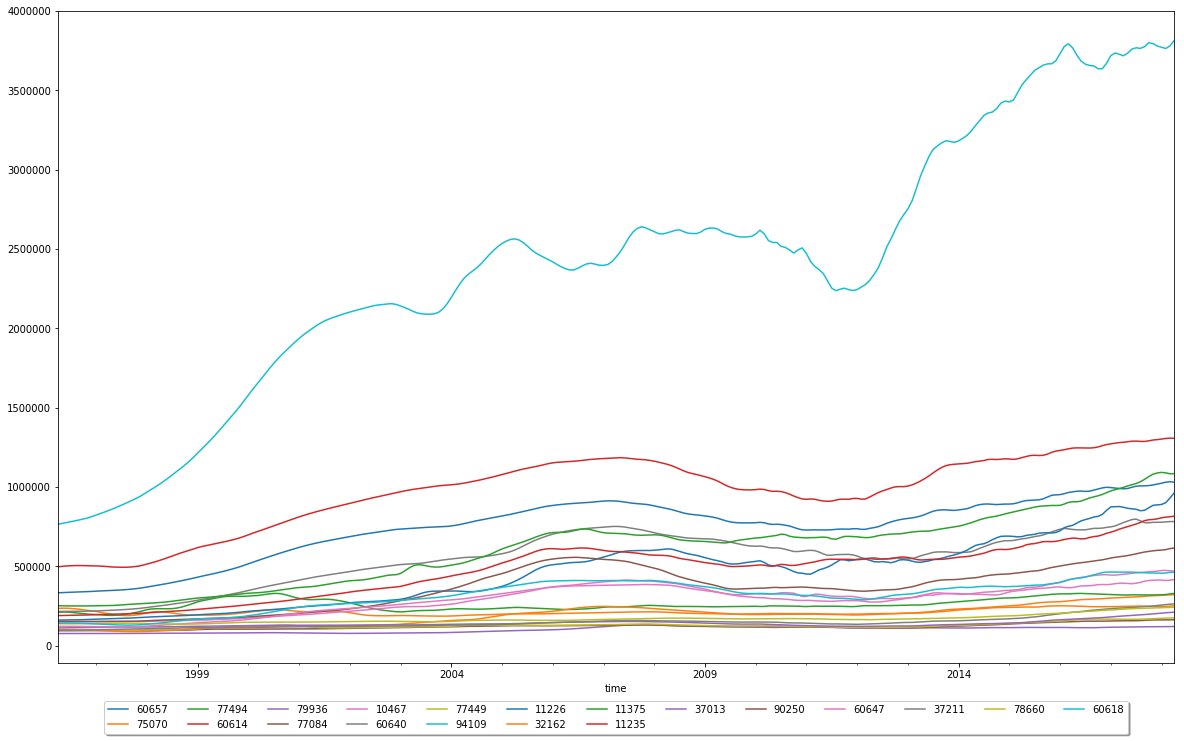

In [391]:
plt.figure(figsize=(20,12))

# list of zipcodes
zipcodes = final_df['zipcode'].unique()

# slice some zipcodes at a time to test only, it takes a very very long time to draw all zipcodes
for zipcode in zipcodes[0:20]:
    final_df.loc[final_df['zipcode'] == zipcode].value.plot(label=zipcode)
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=10)
plt.show()

### From a quick plot above, we see that there are some zipcode was actually growing much stronger over time then others
### Our jobs is to indentify those high-growth zipcodes by developing data models to forecast future growth

### Now, we want to see  seasonality and trend of some zipcodes data

#### Run an ETS Decomposition

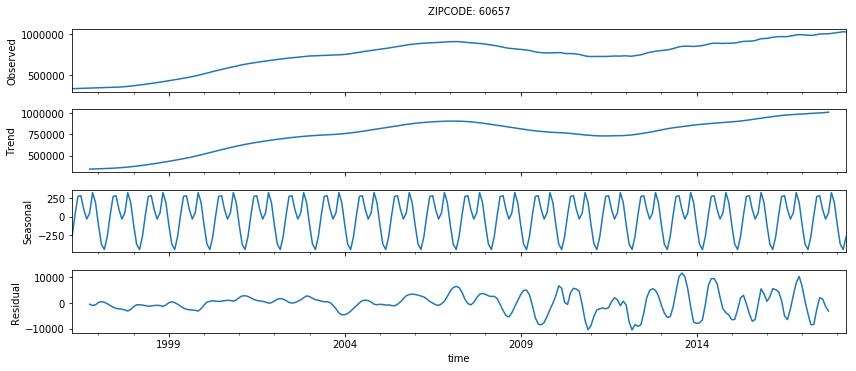

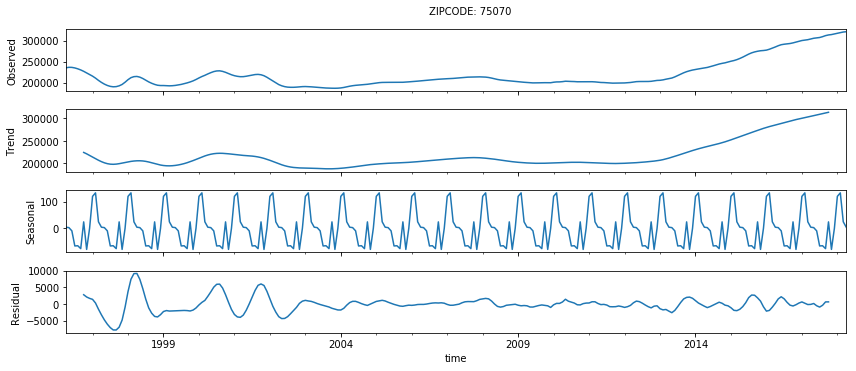

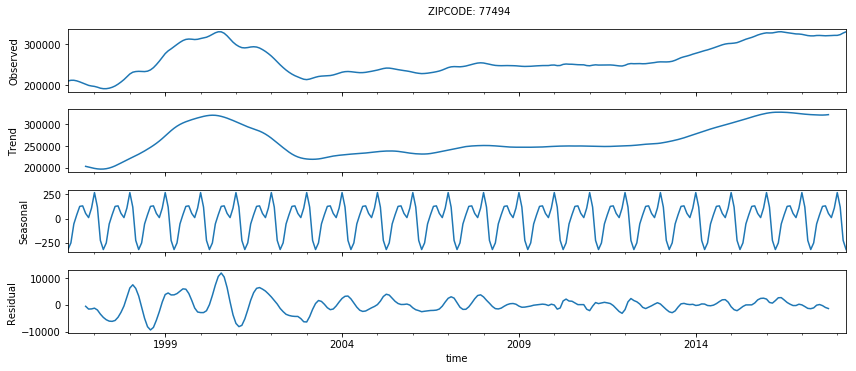

In [392]:
rcParams['figure.figsize'] = 12,5

for zipcode in zipcodes[0:3]:
    results = seasonal_decompose(final_df.loc[final_df['zipcode'] == zipcode].value, model='add')
    fig = results.plot();
    fig.text(0.5, 1, f'ZIPCODE: {zipcode}')

#### Plot ACF and PACF of some zipcodes to check corelation

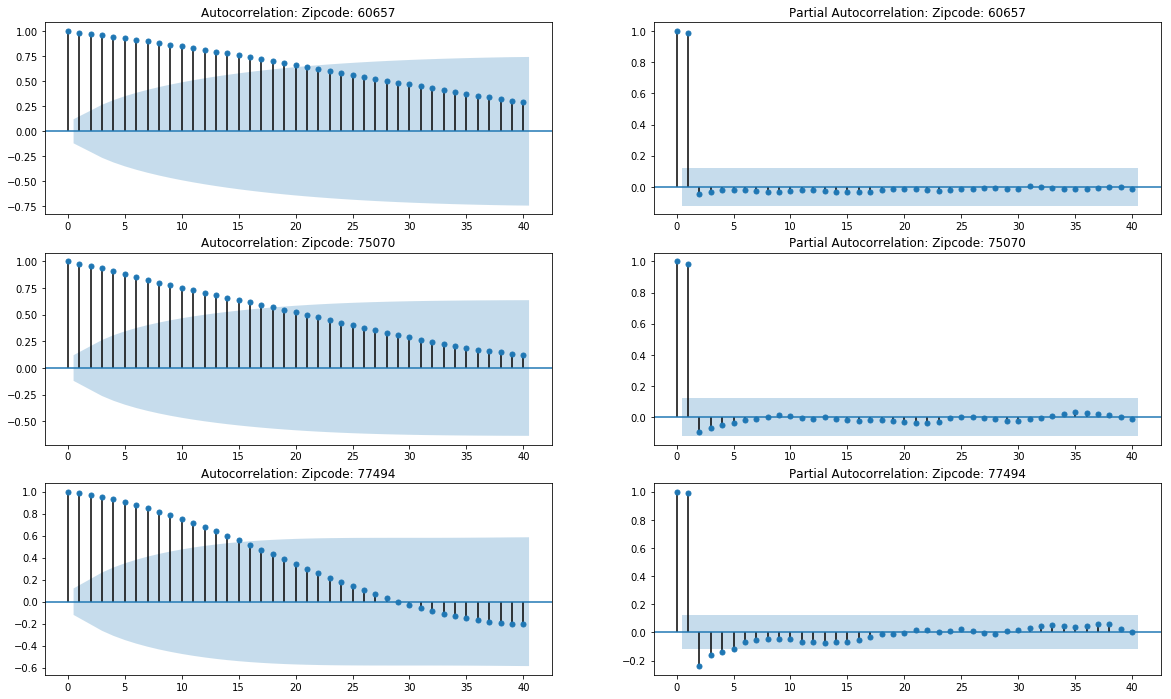

In [393]:
fig = plt.figure(figsize=(20,12))
i = 0
lags=40
for zipcode in zipcodes[0:3]:
    i += 1
    ax = plt.subplot(3,2,i)
    title = f'Autocorrelation: Zipcode: {zipcode}'
    plot_acf(final_df.loc[final_df['zipcode'] == zipcode].value, alpha=0.05, title=title, lags=lags, ax=ax);

    i += 1
    ax = plt.subplot(3,2,i)
    title=f'Partial Autocorrelation: Zipcode: {zipcode}'
    plot_pacf(final_df.loc[final_df['zipcode'] == zipcode].value, alpha=0.05, title=title, lags=lags, ax=ax);

## Automate the Augmented Dickey-Fuller Test
##### Function that performs the augmented Dickey-Fuller Test to determine if an incoming time series is stationary.

In [394]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print("==============================================================")
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print("--------------------------------------------------------------")
    print(out.to_string())
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        
    print("--------------------------------------------------------------")

In [395]:
# check ADF test for some zipcodes
for zipcode in zipcodes[0:3]:
    adf_test(final_df.loc[final_df['zipcode'] == zipcode].value, title= f'ZIPCODE: {i}')

Augmented Dickey-Fuller Test: ZIPCODE: 6
--------------------------------------------------------------
ADF test statistic       -2.298046
p-value                   0.172599
# lags used              16.000000
# observations          248.000000
critical value (1%)      -3.456996
critical value (5%)      -2.873266
critical value (10%)     -2.573019
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
--------------------------------------------------------------
Augmented Dickey-Fuller Test: ZIPCODE: 6
--------------------------------------------------------------
ADF test statistic        0.599300
p-value                   0.987598
# lags used               8.000000
# observations          256.000000
critical value (1%)      -3.456155
critical value (5%)      -2.872897
critical value (10%)     -2.572822
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary

### Again, with the Augmented Dickey-Fuller Test results, all data for all zipcodes are seasonal.



# Step 3: Explore ARIMA Modeling to Find Best Fit Model

### Use grid search to find best fit ARIMA model of one sample zipcode

In [396]:
# test with one zipcode
result = auto_arima(final_df.loc[final_df['zipcode'] == zipcodes[0]].value, 
                    start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=None, D=1, 
                    trace=False, error_action='ignore',suppress_warnings=True, stepwise=True)

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(2, 1, 0)x(0, 1, 0, 12)   Log Likelihood               -2447.750
Date:                            Sun, 03 Nov 2019   AIC                           4903.499
Time:                                    07:48:21   BIC                           4917.617
Sample:                                         0   HQIC                          4909.180
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     78.9959    254.289      0.311      0.756    -419.402     577.393
ar.L1          0.0360      0.005      7.089      0.000       0.026       0.046
ar.L2          0.0209      0.008      2.520      0.012       0.005       0.037
sigma2      1.589e+07      0.009   1.82e+09      0.000    1.59e+07    1.59e+07
===================================================================================
Ljung-Box (Q):                      388.85   Jarque-Bera (JB):                 3.01
Prob(Q):                              0.00   Prob(JB):                         0.22
Heteroskedasticity (H):               3.74   Skew:                             0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.39e+24. Standard errors may be unstable.
"""

#### Now, loop through a sample list  zipcodes to find best fit model for each zipcode
#### And, store the fitted models in to a DataFrame for later dispaly and use

In [397]:
# find the best fit model for each zip code
models = []
for zipcode in zipcodes[0:3]:
    result = auto_arima(final_df.loc[final_df['zipcode'] == zipcode].value, 
                    start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=None, D=1, 
                    trace=False, error_action='ignore',suppress_warnings=True, stepwise=True)
    if result._is_seasonal():
        model = {'zipcode': zipcode, 'model': 'SARIMAX', 'order': result.order, 'seasonal_order': result.seasonal_order}
    else:
        model = {'zipcode': zipcode, 'model': 'ARIMA', 'order': result.order, 'seasonal_order': None}
        
    models.append(model)
    
# convert models list into DataFrame for easy reading
model_df = pd.DataFrame(models, columns=['zipcode', 'model', 'order', 'seasonal_order'])
model_df

,zipcode,model,order,seasonal_order
0,60657,SARIMAX,"(2, 1, 0)","(0, 1, 0, 12)"
1,75070,SARIMAX,"(2, 1, 2)","(0, 1, 1, 12)"
2,77494,SARIMAX,"(1, 0, 1)","(0, 1, 1, 12)"


# Step 4: ARIMA Model Fitting & Forecasting for 1 Test Zipcode

In [398]:
# fit the best model with full historical data for one test zipcode
model_data = model_df.iloc[0]
data = final_df[final_df['zipcode']==model_data['zipcode']]
arima_model = sm.tsa.statespace.SARIMAX(data['value'], order=model_data['order'], seasonal_order=model_data['seasonal_order'], 
                                        enforce_stationarity=False, enforce_invertibility=False)

# fit the model and print results
fitted_model = arima_model.fit()

#### Printing the diagnostics of the model

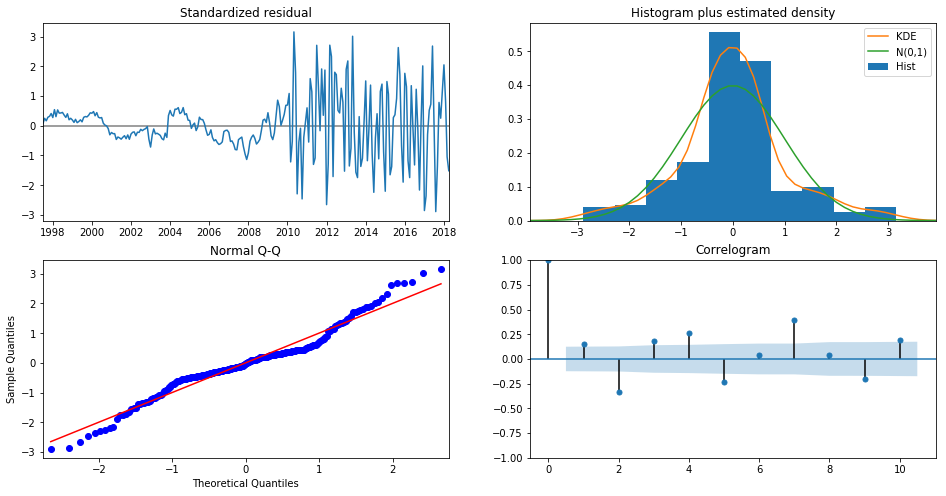

In [399]:
# plot model diagnostics
fitted_model.plot_diagnostics(figsize=(16, 8))
plt.show()

#### Predict value for the next 36 months

In [400]:
# last historical data point
current_data = data.tail(1)
current_data.reset_index(inplace=True)
time = current_data.iloc[0]['time']
zipcode = current_data.iloc[0]['zipcode']
value = current_data.iloc[0]['value']
date_range = pd.date_range(time, periods=37, freq='MS') # first date is present
date_range = date_range[1:] # remove the present date from the date range

In [401]:
# forecast into the future
forecast_values = fitted_model.predict(start=date_range[0], end=date_range[-1], typ='levels').rename('forecasted value')

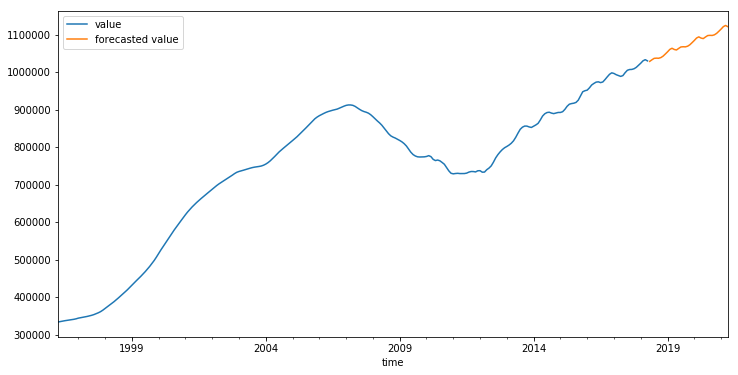

In [402]:
# plot historical and forecasted data
data['value'].plot(legend=True,figsize=(12,6))
forecast_values.plot(legend=True)

In [403]:
# calculate ROI
forecast = pd.DataFrame(forecast_values, index=date_range[:])
value_after_1_year = round(forecast.iloc[1*12-1]['forecasted value'], 0)
value_after_2_year = round(forecast.iloc[2*12-1]['forecasted value'], 0)
value_after_3_year = round(forecast.iloc[3*12-1]['forecasted value'], 0)
forecast_data = {'Zipcode': zipcode, 'Current Value': value, 
                 'Value After 1 Year': value_after_1_year,
                 'Value After 2 Year': value_after_2_year,
                 'Value After 3 Year': value_after_3_year,
                 'ROI After 1 Year': round((value_after_1_year - value) / value, 2),
                 'ROI After 2 Year': round((value_after_2_year - value) / value, 2),
                 'ROI After 3 Year': round((value_after_3_year - value) / value, 2)}
forecast_data

{'Zipcode': 60657,
 'Current Value': 1030600.0,
 'Value After 1 Year': 1061042.0,
 'Value After 2 Year': 1091443.0,
 'Value After 3 Year': 1121843.0,
 'ROI After 1 Year': 0.03,
 'ROI After 2 Year': 0.06,
 'ROI After 3 Year': 0.09}

# Step 5: Modelling and Forecasting The Future for All Zipcodes

#### Now we rewrite all the code for finding best models, fitting models and forecasting into reusable functions to perform forecasting for all the chosen zipcodes

In [404]:
# function to find best fit model
def find_best_fit_models(dataframe):
    """
    This function use auto_arima to find the best fit model for each zipcode
    provided in the ``zipcodes`` list.
    
    Parameters:
    ------------
    dataframe   : the house value time series DataFrame with columns: ['zipcode', 'value']
    
    Return:
    ------------
    A DataFrame with following data columns: ['zipcode', 'model', 'order', 'seasonal_order']
    """
    # list to store best fit models
    models = []
    
    # zipcodes
    zipcodes = dataframe['zipcode'].unique()
    
    # loop through all zipcodes to find best model for each zipcode
    for zipcode in zipcodes:
        # call auto_arima to find best model
        result = auto_arima(dataframe.loc[dataframe['zipcode'] == zipcode].value, 
                            start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=None, D=1, 
                            trace=False, error_action='ignore',suppress_warnings=True, stepwise=True)
        
        # build a model dictionary and put into the returned list
        model = {'zipcode': zipcode, 'model': 'SARIMAX', 'order': result.order, 'seasonal_order': result.seasonal_order}
        models.append(model)

    # convert models list into DataFrame for easy reading
    model_df = pd.DataFrame(models, columns=['zipcode', 'model', 'order', 'seasonal_order'])
    
    return model_df

In [405]:
# function to fit model and forecast future data
def fit_and_forecast(dataframe, model_df):
    """
    This function fit each model in ``model_df`` with the data from ``dataframe``.
    Then, use the fitted model to forecast into the future and calculate the forecasted ROI.
    
    Parameters:
    -----------
    dataframe   : the house value time series DataFrame with columns: ['zipcode', 'value']
    model_df    : the model DataFrame output from function ``find_best_fit_models``
    
    Return:
    -----------
    A DataFrame with forecasted data,
    And a DataFrame with forecasted ROI data
    """
    
    # forecast data to be returned
    ROIs = []
    forecasts = []
    
    # loop through all model in model_df
    for index, model in model_df.iterrows():                
        # fit the best model with full historical data for one test zipcode
        data = dataframe[dataframe['zipcode']==model['zipcode']]
        arima_model = sm.tsa.statespace.SARIMAX(data['value'], order=model['order'], 
                                                seasonal_order=model['seasonal_order'], 
                                                enforce_stationarity=False, enforce_invertibility=False)

        # fit the model and print results
        fitted_model = arima_model.fit()
    
        # last historical data point
        current_data = data.tail(1)
        current_data.reset_index(inplace=True)
        time = current_data.iloc[0]['time']
        zipcode = current_data.iloc[0]['zipcode']
        value = current_data.iloc[0]['value']
        
        # build forecast date range
        date_range = pd.date_range(time, periods=37, freq='MS') # first date is present
        date_range = date_range[1:] # remove the first date
        
        # forecast values of the future
        forecast_values = fitted_model.predict(start=date_range[0],
                  end=date_range[-1], typ='levels').rename('value')
        
        # build forecast dataframe
        forecast_df = pd.DataFrame(forecast_values, index=date_range[:])
        forecast_df['zipcode'] = zipcode
        forecasts.append(forecast_df)
        
        # calculate and build forecasted ROI dataframe
        value_after_1_year = round(forecast_df.iloc[1*12-1]['value'], 0)
        value_after_2_year = round(forecast_df.iloc[2*12-1]['value'], 0)
        value_after_3_year = round(forecast_df.iloc[3*12-1]['value'], 0)
        roi_data = {'Zipcode': zipcode, 
                         'Current Value': value, 
                         'Value After 1 Year': value_after_1_year,
                         'Value After 2 Year': value_after_2_year,
                         'Value After 3 Year': value_after_3_year,
                         'ROI After 1 Year': round((value_after_1_year - value) / value, 2),
                         'ROI After 2 Year': round((value_after_2_year - value) / value, 2),
                         'ROI After 3 Year': round((value_after_3_year - value) / value, 2)}
        ROIs.append(roi_data)
    
    # convert models list into DataFrame for easy reading
    roi_df = pd.DataFrame(ROIs, columns=['Zipcode', 'Current Value', 
                           'Value After 1 Year', 'Value After 2 Year', 'Value After 3 Year',
                                'ROI After 1 Year', 'ROI After 2 Year', 'ROI After 3 Year'])
    
    # merge all forecasts into one DataFrame
    forecast_df = pd.concat(forecasts)
    
    return forecast_df, roi_df
    

### Now we want to forecast and calculate forecasted future ROI
#### However, to run for the whole dataset with a normal computer it may takes days to finish, so we will run for one State at a time
#### In this test, we assume we want to run forecast for the state California `CA` only.

#### There are 2 options, which depends in target customer, we might have a look  on profit 

In [229]:
# Now, forecast the real data of California
dataframe = final_df[final_df['state']=='CA']

# find best models
model_df = find_best_fit_models(dataframe)

# fit and forecast
forecast_df, roi_df = fit_and_forecast(dataframe, model_df)

# show result
roi_df

,Zipcode,Current Value,Value After 1 Year,Value After 2 Year,Value After 3 Year,ROI After 1 Year,ROI After 2 Year,ROI After 3 Year
0,94109,3813500.0,3980863.0,3998647.0,4000537.0,0.04,0.05,0.05
1,90250,616200.0,640778.0,658125.0,670370.0,0.04,0.07,0.09
2,94565,430100.0,464343.0,491166.0,511258.0,0.08,0.14,0.19
3,90046,1966900.0,1883392.0,1848046.0,1833086.0,-0.04,-0.06,-0.07
4,94501,1059700.0,1071992.0,1075278.0,1076247.0,0.01,0.01,0.02
5,90034,1419100.0,1511500.0,1603900.0,1696300.0,0.07,0.13,0.20
6,94110,1594000.0,1882000.0,2170000.0,2458000.0,0.18,0.36,0.54
7,90044,421100.0,431513.0,435654.0,438164.0,0.02,0.03,0.04
8,90805,459100.0,470337.0,479275.0,486383.0,0.02,0.04,0.06
9,95630,542900.0,532545.0,527721.0,525472.0,-0.02,-0.03,-0.03


# Step 6: Interpreting Results & Making Conclusions

#### Sort the ROI values to get the Top 5 performers

In [290]:
# sort the get top 5 performers order by After 1st Year
top_5_after_3_year = roi_df.sort_values(['ROI After 3 Year', 'ROI After 2 Year', 'ROI After 1 Year'],
                     ascending=False).head(5)
top_5_after_3_year

,Zipcode,Current Value,Value After 1 Year,Value After 2 Year,Value After 3 Year,ROI After 1 Year,ROI After 2 Year,ROI After 3 Year
1,95050,1385100.0,1803900.0,2222700.0,2641500.0,0.30,0.60,0.91
4,93924,1015200.0,1321200.0,1627200.0,1933200.0,0.30,0.60,0.90
0,95035,1160700.0,1506300.0,1851900.0,2197500.0,0.30,0.60,0.89
3,95054,1368000.0,1760400.0,2152800.0,2545200.0,0.29,0.57,0.86
2,95128,1253000.0,1608200.0,1963400.0,2318600.0,0.28,0.57,0.85


### So the Top 5 Zipcodes that would forecastedly produce most return would be in the zipcodes list above


#### Plot the historical and forecasted values of Top 5 Performers

use f instead of forcasted

In [294]:
# top 5 zipcodes
top_5_zipcodes = top_5_after_3_year['Zipcode'].unique()
print(f'Top 5 Zipcodes with max return in 3 years are: {top_5_zipcodes}')

# top 5 dataframe
top_5_df = final_df.loc[final_df['zipcode'].isin(top_5_zipcodes)]

# top 5 forecasted dataframe
top_5_forecast_df = forecast_df[forecast_df['zipcode'].isin(top_5_zipcodes)]

Top 5 Zipcodes with max return in 3 years are: [95050 93924 95035 95054 95128]


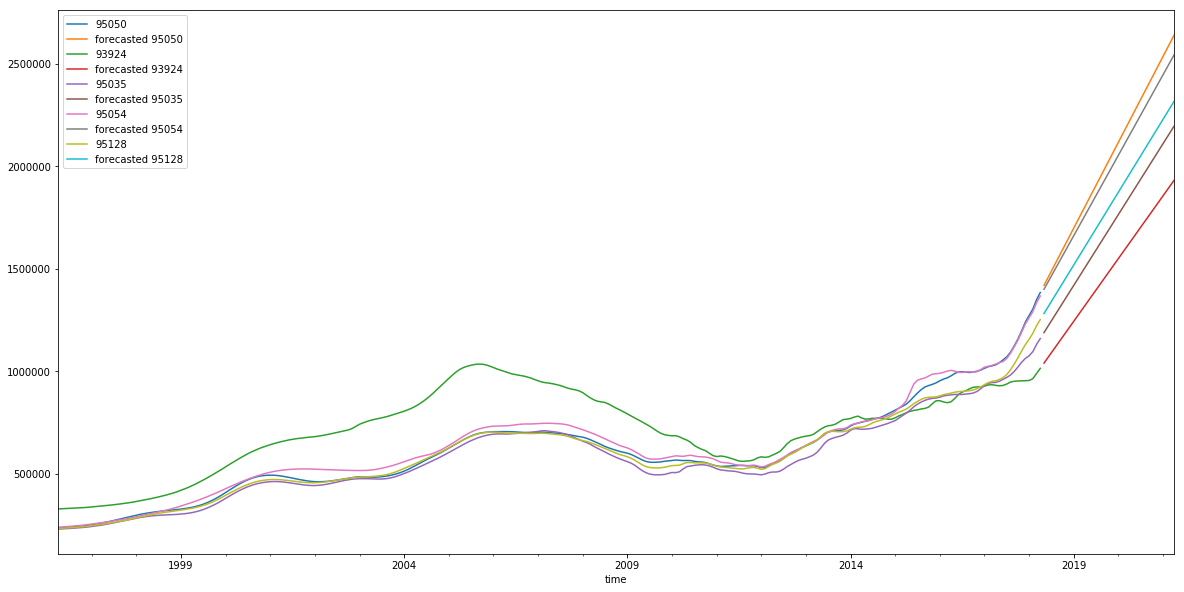

In [292]:
# plot historical value and forecasted value of Top 5 Performers
for zipcode in top_5_zipcodes:
    data = top_5_df[top_5_df['zipcode']==zipcode]
    col_name = str(zipcode)
    data[col_name] = data['value']
    data[col_name].plot(legend=True, figsize=(20,10))
    
    forecast = forecast_df[forecast_df['zipcode']==zipcode]
    col_name = 'forecasted ' + str(zipcode)
    forecast[col_name] = forecast['value']
    forecast[col_name].plot(legend=True)